# Multi-layer Perceptron regressor

## Notebook configuration

In [48]:
%matplotlib inline

In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
plt.rcParams["figure.figsize"] = (14, 7)

## Use case

We try to train a neural network to approximate the following function:

$$
\large f(x) = 5 * (tanh(x + y) + 1)
$$


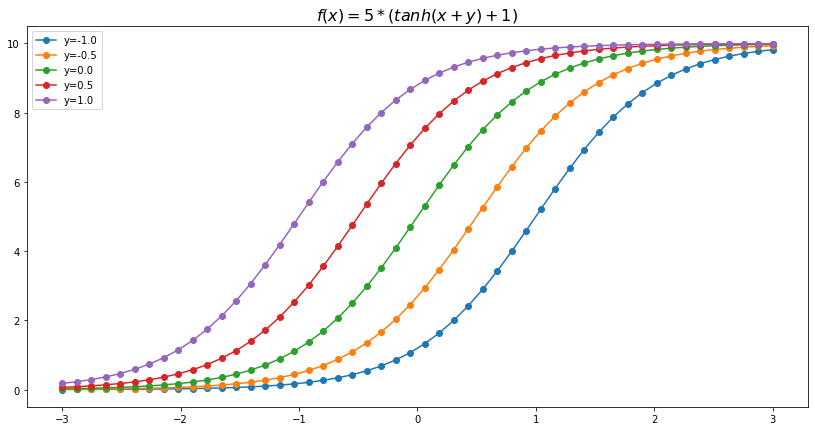

In [638]:
x = np.linspace(-3., 3., 50)
y = np.linspace(-1., 1., 5)
for _y in y:
    plt.plot(x, 5 * (np.tanh(x + _y) + 1.), label=f"y={_y}", marker='o')
plt.title(r"$f(x)=5 * (tanh(x + y) + 1)$", fontsize=16)
plt.legend();

## Generation of training and testing data

We generate data by running the function on random samples:

In [641]:
n = 2000
x1 = np.random.uniform(-3., 3., n).reshape((n, 1))
x2 = np.random.uniform(-1., 1., n).reshape((n, 1))
x = np.concatenate((x1, x2), axis=1)

In [642]:
y = 5 * (np.tanh(x[:, 0] + x[:, 1]) + 1.)
y = y.reshape((y.shape[0], 1))

We keep a part of data for testing:

In [643]:
test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

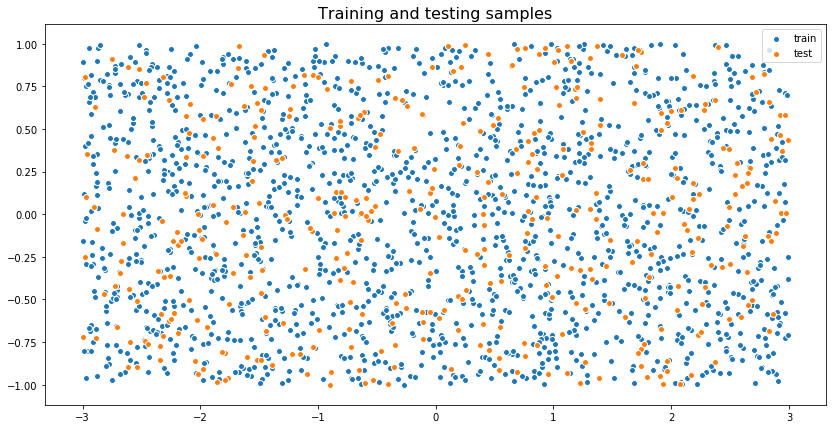

In [644]:
plt.scatter(x_train[:, 0], x_train[:, 1], label="train", edgecolor='w')
plt.scatter(x_test[:, 0], x_test[:, 1], label="test", edgecolor='w')
plt.title("Training and testing samples", fontsize=16)
plt.legend();

## Scaling input and output variables

The grid search algorithm does not apply scaling on outputs so we need to do this manually. The input data on the other side will be managed by the grid algorithm:

In [647]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [648]:
y_train_scaled = y_scaler.fit_transform(y_train)

## Configuring the pipeline and the grid search algorithm

We use a pipeline which includes the scaler for inputs as well as the regressor itself:

In [649]:
regressor = MLPRegressor()
pipeline = Pipeline([
    ("scaler", x_scaler),
    ("regressor", regressor)
])
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
  ('regressor',
   MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
                beta_2=0.999, early_stopping=False, epsilon=1e-08,
                hidden_layer_sizes=(100,), learning_rate='constant',
                learning_rate_init=0.001, max_fun=15000, max_iter=200,
                momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
                power_t=0.5, random_state=None, shuffle=True, solver='adam',
                tol=0.0001, validation_fraction=0.1, verbose=False,
                warm_start=False))],
 'verbose': False,
 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'regressor': MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=1500

We decide to go with number of neurons in hidden layers:

In [650]:
params = {
    "regressor__activation": ["relu"],
    "regressor__hidden_layer_sizes": [(25,), (50,), (100,), (200,), (400,), (800,)],
    "regressor__solver": ["lbfgs"],
}

The *refit* parameter enables to refit the best regressor with the whole dataset. Internally the grid algorithm performs a cross validation using a 10-fold method (at each iteration 10% of the data is used for testing).

In [651]:
grid = GridSearchCV(pipeline, params, cv=10, n_jobs=4, refit=True)

## Fitting the model

We pass the scaled outputs for the training:

In [653]:
grid.fit(x_train, y_train_scaled.ravel())

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('regressor',
                                        MLPRegressor(activation='relu',
                                                     alpha=0.0001,
                                                     batch_size='auto',
                                                     beta_1=0.9, beta_2=0.999,
                                                     early_stopping=False,
                                                     epsilon=1e-08,
                                                     hidden_layer_sizes=(100,),
                                                     learning_rate='constant',
                                                     learning_rate_init=0.001,
   

We display the parameters of the best regressors:

In [655]:
(pd
 .DataFrame(grid.cv_results_)
 .sort_values("rank_test_score", ascending=True)
 .filter(regex=r"regressor|mean_test_score")
)

,param_regressor__activation,param_regressor__hidden_layer_sizes,param_regressor__solver,mean_test_score
5,relu,"(800,)",lbfgs,0.999905
4,relu,"(400,)",lbfgs,0.999872
3,relu,"(200,)",lbfgs,0.999833
2,relu,"(100,)",lbfgs,0.999758
1,relu,"(50,)",lbfgs,0.999311
0,relu,"(25,)",lbfgs,0.998814


## Estimating the error on the test samples

We calculate the error on the test samples:

In [658]:
y_hat_scaled = grid.predict(x_test)

In [659]:
y_hat_scaled.shape

(400,)

In [660]:
y_hat = (y_scaler
         .inverse_transform(y_hat_scaled.reshape(y_hat_scaled.shape[0], 1))
         .reshape((y_hat_scaled.shape[0], 1))
)

In [661]:
dy = y_hat - y_test
print(f"Error max: {np.max(np.abs(dy))}")
print(f"Error RMS: {np.sqrt((dy**2).sum()) / dy.shape[0]}")

Error max: 0.10002987513045987
Error RMS: 0.0019295313733684342


## Plotting with neural network

Now we make a plot on the definition domain with the approximated function:

In [662]:
x1 = np.linspace(-3., 3., 50)
x2 = np.linspace(-1., 1., 5)
x1, x2 = np.meshgrid(x1, x2)
x1 = x1.reshape((x1.shape[0] * x1.shape[1], 1))
x2 = x2.reshape((x2.shape[0] * x2.shape[1], 1))
x = np.concatenate((x1, x2), axis=1)

In [663]:
y = grid.predict(x)
y = y_scaler.inverse_transform(y.reshape(y.shape[0], 1)).reshape((y.shape[0], 1))

In [664]:
y = y.reshape((5, 50))

In [665]:
x1 = x1.reshape((5, 50))
x2 = x2.reshape((5, 50))

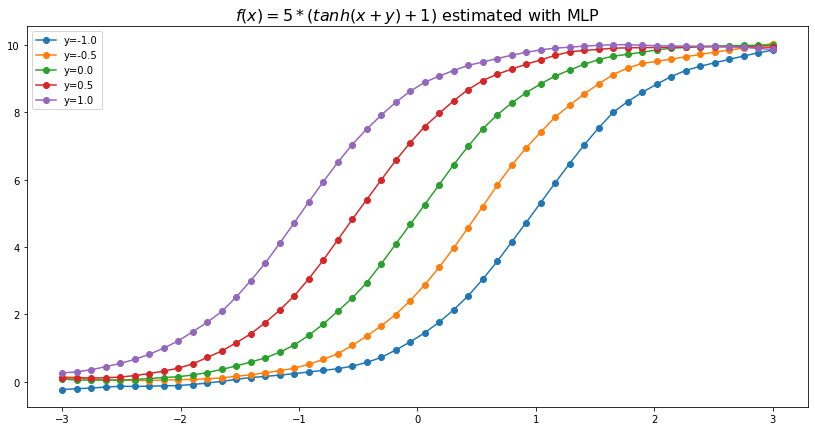

In [666]:
for _x2 in sorted(np.unique(x2)):
    label = f"y={_x2}"
    mask = (x2 == _x2)
    _x1 = x1[mask]
    _y = y[mask]
    plt.plot(_x1, _y, label=label, marker='o')
plt.title(r"$f(x)=5 * (tanh(x + y) + 1)$ estimated with MLP", fontsize=16)
plt.legend();

An estimation of the error on the domain:

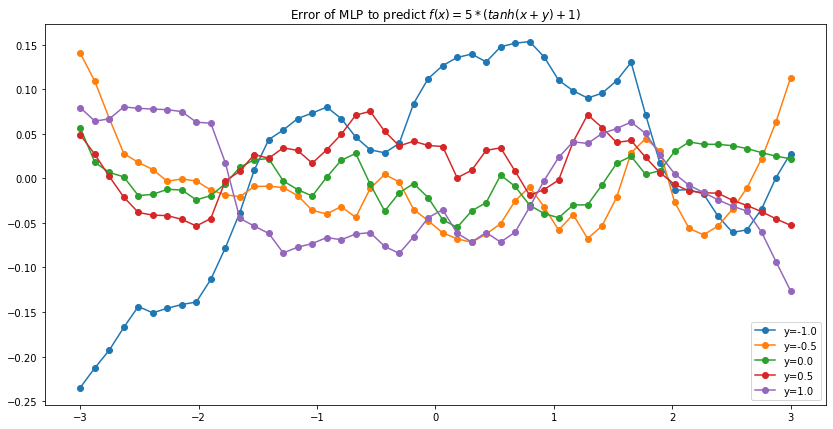

In [667]:
for _x2 in sorted(np.unique(x2)):
    label = f"y={_x2}"
    mask = (x2 == _x2)
    _x1 = x1[mask]
    _y_hat = y[mask]
    _y = 5 * (np.tanh(_x + _x2) + 1.)
    plt.plot(_x, _y_hat - _y, label=label, marker='o')
plt.title(r"Error of MLP to predict $f(x)=5 * (tanh(x + y) + 1)$")
plt.legend();

## Parameters of the MLP

In [668]:
regressor = grid.best_estimator_.named_steps["regressor"]

3 layers (1 input, 1 output, 1 hidden):

In [669]:
regressor.n_layers_

3

A single output:

In [624]:
regressor.n_outputs_

1

2 inputs and 800 neurons on the hidden layer, number of weights for the hidden layer:

In [671]:
regressor.coefs_[0].shape

(2, 800)

1 output and 800 neurons on the output layer:

In [672]:
regressor.coefs_[1].shape

(800, 1)

The biases for the hidden layer:

In [673]:
regressor.intercepts_[0].shape

(800,)

The biases for the output layer:

In [635]:
regressor.intercepts_[1].shape

(1,)

We save the MLP model for a later re-use:

In [677]:
import pickle
with open("mlp.model", mode="wb") as fobj:
    pickle.dump(regressor, fobj)